In [1]:
!pip install -q segmentation_models_pytorch

In [2]:
import pandas as pd
import numpy as np

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp #float16 precision
import segmentation_models_pytorch as smp
import torchvision.models as models
# from torchmetrics import Metric
# from torchmetrics import MetricCollection
# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

import os
import time
import random
import copy
from pathlib import Path
from typing import Callable
from typing import List
from typing import Optional
from typing import Tuple
from tqdm import tqdm

# For colored terminal text
from colorama import Fore, Back, Style

In [3]:
class CFG:
    IMG_SIZE = [320, 384]
    KAGGLE_DIR = Path("/") / "kaggle"
    INPUT_DIR = KAGGLE_DIR / "input"
    OUTPUT_DIR = KAGGLE_DIR / "working"

    DATA_DIR = INPUT_DIR / "uw-madison-gi-tract-image-segmentation"
    INPUT_TRAIN_DIR = INPUT_DIR / "uwmgisegmentationpreprocessed"
    
    DEBUG = False # Debug complete pipeline

    N_SPLITS = 5
    SEED = 42
    USE_DEPTH = True # True for 2.5D data
    USE_AUGS = True
    BATCH_SIZE = 64
    NUM_WORKERS = 2
    ARCH = "Unet"
    ENCODER_NAME = "efficientnet-b1"
    ENCODER_WEIGHTS = "imagenet"
    LOSS = ["bce", "tversky"]
    OPTIMIZER = "Adam"
    NUM_CLASSES = 3
    TRAIN_BS      = 64
    VALID_BS      = TRAIN_BS*2
    LEARNING_RATE = 2e-3
    WEIGHT_DECAY = 1e-6
    SCHEDULER = "CosineAnnealingLR"
    MIN_LR = 1e-6
    NUM_EPOCHS = 2 if DEBUG else 10
    T_MAX = int(30_000 / TRAIN_BS * NUM_EPOCHS) + 50
    T_0 = 25
    THR = 0.45
    resume_training = False
    saved_weights_dir = ""

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    FOLDS=[0,1] if DEBUG else [0]
    
    imp_color  = Fore.GREEN
    reset_style = Style.RESET_ALL

In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.SEED)

> SEEDING DONE


In [5]:
train_data_dir = CFG.INPUT_TRAIN_DIR
os.listdir(train_data_dir)

['images', 'train_preprocessed.csv', 'masks']

In [6]:
train_df = pd.read_csv(train_data_dir / 'train_preprocessed.csv')
train_df.head()

,id,segmentation,rle_len,empty,case,day,slice,image_path,width,height,spacing,fold,mask_path,image_paths
0,case123_day20_slice_0001,"['', '', '']",0,True,123,20,1,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,3.0,../input/uw-madison-gi-tract-image-segmentatio...,['../input/uw-madison-gi-tract-image-segmentat...
1,case123_day20_slice_0002,"['', '', '']",0,True,123,20,2,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,3.0,../input/uw-madison-gi-tract-image-segmentatio...,['../input/uw-madison-gi-tract-image-segmentat...
2,case123_day20_slice_0003,"['', '', '']",0,True,123,20,3,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,3.0,../input/uw-madison-gi-tract-image-segmentatio...,['../input/uw-madison-gi-tract-image-segmentat...
3,case123_day20_slice_0004,"['', '', '']",0,True,123,20,4,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,3.0,../input/uw-madison-gi-tract-image-segmentatio...,['../input/uw-madison-gi-tract-image-segmentat...
4,case123_day20_slice_0005,"['', '', '']",0,True,123,20,5,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,3.0,../input/uw-madison-gi-tract-image-segmentatio...,['../input/uw-madison-gi-tract-image-segmentat...


In [7]:
train_df['image_path'] = train_df['image_path'].str.replace("uw-madison-gi-tract-image-segmentation-preprocessed", "uwmgisegmentationpreprocessed/images/images")
train_df['mask_path'] = train_df['mask_path'].str.replace("uw-madison-gi-tract-image-segmentation-preprocessed", "uwmgisegmentationpreprocessed/masks")

In [8]:
train_df.head()

,id,segmentation,rle_len,empty,case,day,slice,image_path,width,height,spacing,fold,mask_path,image_paths
0,case123_day20_slice_0001,"['', '', '']",0,True,123,20,1,../input/uwmgisegmentationpreprocessed/images/...,266,266,1.5,3.0,../input/uwmgisegmentationpreprocessed/masks/m...,['../input/uw-madison-gi-tract-image-segmentat...
1,case123_day20_slice_0002,"['', '', '']",0,True,123,20,2,../input/uwmgisegmentationpreprocessed/images/...,266,266,1.5,3.0,../input/uwmgisegmentationpreprocessed/masks/m...,['../input/uw-madison-gi-tract-image-segmentat...
2,case123_day20_slice_0003,"['', '', '']",0,True,123,20,3,../input/uwmgisegmentationpreprocessed/images/...,266,266,1.5,3.0,../input/uwmgisegmentationpreprocessed/masks/m...,['../input/uw-madison-gi-tract-image-segmentat...
3,case123_day20_slice_0004,"['', '', '']",0,True,123,20,4,../input/uwmgisegmentationpreprocessed/images/...,266,266,1.5,3.0,../input/uwmgisegmentationpreprocessed/masks/m...,['../input/uw-madison-gi-tract-image-segmentat...
4,case123_day20_slice_0005,"['', '', '']",0,True,123,20,5,../input/uwmgisegmentationpreprocessed/images/...,266,266,1.5,3.0,../input/uwmgisegmentationpreprocessed/masks/m...,['../input/uw-madison-gi-tract-image-segmentat...


In [9]:
def load_img(path):
    img = np.load(path)
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_mask(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk
    

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [10]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

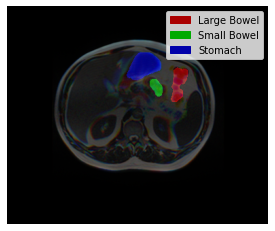

In [11]:
sample = train_df[~train_df['empty']].iloc[20]
img = load_img(sample.image_path)
mask = load_mask(sample.mask_path)
show_img(img, mask=mask)

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, use_depth_image: bool, has_mask: bool, transforms: Optional[Callable] = None):
        self.df = df
        self.use_depth_image = use_depth_image
        self.transforms = transforms
        self.has_mask = has_mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        if self.use_depth_image:
            image = self.load_image(row["image_path"])
#             image = np.transpose(image, (2, 0, 1))
        else:
            image = self.load_orig_image((row["image_paths"][0]))

        if self.has_mask:
            mask = self.load_mask(row["mask_path"])
#             mask = np.transpose(mask, (2, 0, 1))
            if self.transforms:
                data = self.transforms(image=image, mask=mask)
#                 print(f"Image shape: {idx} {image.shape}")
#                 print(f"Mask shape: {idx} {mask.shape}")
                image, mask = data["image"], data["mask"]

            return image, mask
        
        else:
            id_ = row["id"]
            h, w = image.shape[:2]

            if self.transforms:
                data = self.transforms(image=image)
                image = data["image"]

            return image, id_, h, w 
    
#     @staticmethod
#     def _load_images(self, paths):
#         images = [self._load_image(path, tile=False) for path in paths]
#         image = np.stack(images, axis=-1)
#         return image

    @staticmethod
    def load_image(path):
        img = np.load(path).astype('float32')
        mx = np.max(img)
        if mx:
            img/=mx # scale image to [0, 1]
        return img
    
    @staticmethod
    def load_orig_image(path):
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        image = image.astype("float32")  # original is uint16
        image = np.tile(image[..., None], [1, 1, 3])  # gray to rgb  
        image /= image.max()

        return image

    @staticmethod
    def load_mask(path):
        return np.load(path).astype("float32") / 255.0

In [13]:
# mask = Dataset.load_mask(sample.mask_path)
# # mask.shape()
# mask.shape

In [14]:
def get_transforms(split='train', img_size = CFG.IMG_SIZE):
    if split == 'valid':
        return A.Compose([
    #         A.Resize(img_size, interpolation=cv2.INTER_NEAREST),
            ToTensorV2(transpose_mask=True)
            ], p=1.0)
    elif split == 'train':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
    #         A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            A.RandomResizedCrop(*img_size, scale=(0.1, 1.0), ratio=(0.9, 1.1), interpolation=1, always_apply=False, p=0.5),
            A.OneOf([
                A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
    # #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            A.CoarseDropout(max_holes=8, max_height=img_size[0]//20, max_width=img_size[1]//20,
                             min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ToTensorV2(transpose_mask=True)
            ], p=1.0)

In [15]:
def prepare_loaders(df, fold,debug=False):
    train_df = df[df.fold != fold].reset_index(drop=True)
    valid_df = df[df.fold == fold].reset_index(drop=True)
    if debug:
        train_df = train_df[train_df['empty'] == False].head(32*5)
        valid_df = valid_df[valid_df['empty'] == False].head(32*3)
    train_dataset = Dataset(train_df, CFG.USE_DEPTH, True, transforms=get_transforms('train') if CFG.USE_AUGS else [])
    valid_dataset = Dataset(valid_df, CFG.USE_DEPTH, True, transforms=get_transforms('valid') if CFG.USE_AUGS else [])

    train_loader = DataLoader(train_dataset, batch_size=CFG.TRAIN_BS if not debug else 20, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.VALID_BS if not debug else 20, 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [16]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()
        msk = msks[idx,].permute((1, 2, 0)).numpy()
        if msks is not None:
            show_img(img, msk)
        else:
            show_img(img)
    plt.tight_layout()
    plt.show()

In [17]:
train_loader, valid_loader = prepare_loaders(train_df, fold=0, debug=True)

torch.Size([20, 3, 320, 384]) torch.Size([20, 3, 320, 384])


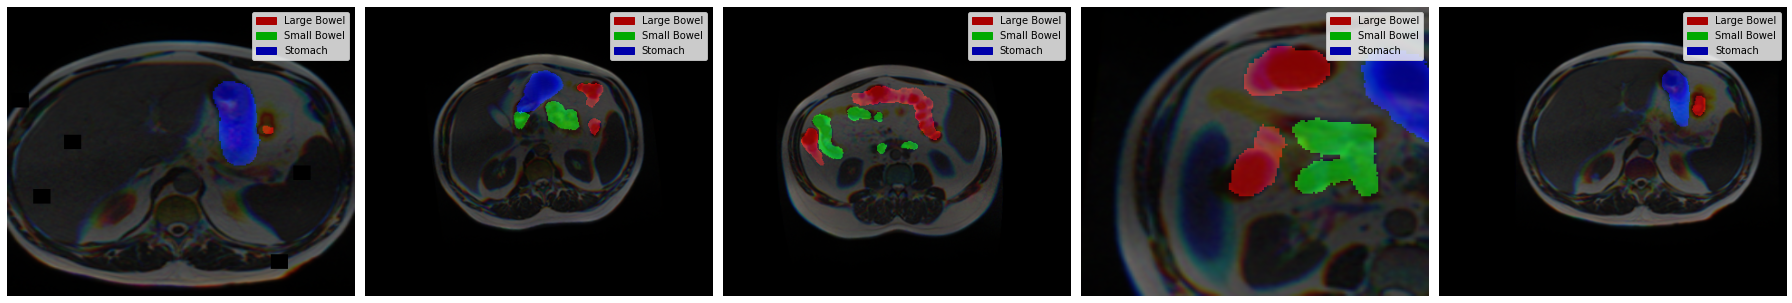

In [18]:
imgs, msks = next(iter(train_loader))
print(imgs.shape, msks.shape)
# imgs, _, _, _ = next(iter(train_loader))

plot_batch(imgs, msks, size=5)
# plot_batch(imgs, None,size = 5)

In [19]:
import gc
gc.collect()

20630

In [20]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

In [21]:
class SegmentationModel(nn.Module):
    def __init__(self, arch:str ,encoder_name:str, encoder_weights:str, num_classes:int):
        super(SegmentationModel, self).__init__()
        self.arch = arch
        self.encoder_name = encoder_name
        self.encoder_weights = encoder_weights

        self.model = smp.create_model(
            self.arch,
            encoder_name=self.encoder_name,
            encoder_weights=self.encoder_weights,
            in_channels=3,
            classes=num_classes,
            activation=None,
        )
            
    def forward(self, images):
        return self.model(images)
        

In [22]:
class Trainer:
    LOSS_FNS = {
        "bce": smp.losses.SoftBCEWithLogitsLoss(),
        "dice": smp.losses.DiceLoss(mode="multilabel"),
        "focal": smp.losses.FocalLoss(mode="multilabel"),
        "jaccard": smp.losses.JaccardLoss(mode="multilabel"),
        "lovasz": smp.losses.LovaszLoss(mode="multilabel"),
        "tversky": smp.losses.TverskyLoss(mode="multilabel"),
    }
    
    def __init__(
        self,
        model,
        loss: [str], 
        optimizer: str,
        learning_rate: float, 
        weight_decay: float, 
        scheduler: Optional[str], 
        T_max: int, 
        T_0: int,
        min_lr: int,
        fold: int,
        train_dataloader,
        val_dataloader,
        device,
        model_dir: Optional[str],
        load_saved_weights: bool = False,
    ):
        self.model_dir = model_dir
        self.model = model
        self.device = device
        self.fold = fold
        self.model.to(self.device)
        self.train_loader = train_dataloader
        self.val_loader = val_dataloader
        self.criterion = self.init_criterion(loss)
        self.lr = learning_rate
        self.wd = weight_decay
        self.optimizer = self.configure_optimizer(optimizer, self.lr, self.wd)
        self.scheduler_name = scheduler
        if scheduler is not None:
            self.scheduler = self.configure_scheduler(self.optimizer, scheduler, T_max, T_0, min_lr)
        else:
            self.scheduler = None

        self.train_loss_history = []
        self.validation_loss_history = []
        self.validation_dice_history = []
        self.validation_iou_history = []

        if os.path.exists(model_dir) and load_from_disk:
            checkpoint = torch.load(os.path.join(self.model_dir, "checkpoint.pt"))
            self.model.load_state_dict(checkpoint["model_state_dict"])
            self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.model.train()
    
    def init_criterion(self, losses):
        loss_fns = [self.LOSS_FNS[loss] for loss in losses]
        def criterion(y_pred, y_true):
            return sum(loss_fn(y_pred, y_true) for loss_fn in loss_fns) / len(loss_fns)
        return criterion
    
    def init_training_history(self):
        self.train_loss_history = []
        self.validation_loss_history = []
        self.validation_dice_history = []
        self.validation_iou_history = []
    
    def reset_training_history(self):
        init_training_history()
    
    def configure_optimizer(self,optimizer, lr, wd):
        optimizer_kwargs = dict(
            params=self.model.parameters(), lr=lr, weight_decay=wd
        )
        if optimizer == "Adadelta":
            opt = torch.optim.Adadelta(**optimizer_kwargs)
        elif optimizer == "Adagrad":
            opt = torch.optim.Adagrad(**optimizer_kwargs)
        elif optimizer == "Adam":
            opt = torch.optim.Adam(**optimizer_kwargs)
        elif optimizer == "AdamW":
            opt = torch.optim.AdamW(**optimizer_kwargs)
        elif optimizer == "Adamax":
            opt = torch.optim.Adamax(**optimizer_kwargs)
        elif optimizer == "SGD":
            opt = torch.optim.SGD(**optimizer_kwargs)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")
            
        return opt
    
    def configure_scheduler(self,optimizer,scheduler, T_max, T_0, min_lr):
        if scheduler == "CosineAnnealingLR":
            sch = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=T_max, eta_min=min_lr
            )
        elif scheduler == "CosineAnnealingWarmRestarts":
            sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=T_0, eta_min=min_lr
            )
        elif scheduler == "ExponentialLR":
            sch = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler == "ReduceLROnPlateau":
            sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',patience=3, factor=0.1)
        else:
            raise ValueError(f"Unknown scheduler: {self.hparams.scheduler}")

        return sch

    def save_model(self,save_type:str, epoch: int, fold: int) -> None:
        """
        Saves the model state and optimizer state on the dict
        """
        path = f"{save_type}_epoch-{fold:02d}.pt"
        torch.save(self.model.state_dict(), path)
    
    def train_epoch(self):
        """Implements the main training loop."""
        self.model.train()
        scaler = amp.GradScaler()

        dataset_size = 0
        running_loss = 0.0

        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader), desc='Train ')
        for step, (images, masks) in pbar:         
            images = images.to(self.device, dtype=torch.float)
            masks  = masks.to(self.device, dtype=torch.float)
            batch_size = images.size(0)
            
            # zero the parameter gradients
            self.optimizer.zero_grad()

            with amp.autocast(enabled=True):
                y_pred = self.model(images)
                loss   = self.criterion(y_pred, masks)

            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler is not None and self.scheduler_name in ["CosineAnnealingWarmRestarts", "CosineAnnealingLR"]:
                self.scheduler.step()

            running_loss += (loss.item() * batch_size)
            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            current_lr = self.optimizer.param_groups[0]['lr']
            pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                            lr=f'{current_lr:0.5f}',
                            gpu_mem=f'{mem:0.2f} GB')
            torch.cuda.empty_cache()
            gc.collect()

        if self.scheduler is not None and self.scheduler_name in ["ReduceLROnPlateau", "ExponentialLR"]:
            if self.scheduler_name == "ExponentialLR":
                self.scheduler.step()

        return epoch_loss

    def validate(self):
        """Evaluate on held-out split (either val or test)"""
        self.model.eval()
    
        dataset_size = 0
        running_loss = 0.0

        val_scores = []

        pbar = tqdm(enumerate(self.val_loader), total=len(self.val_loader), desc='Valid ')
        for step, (images, masks) in pbar:        
            images  = images.to(self.device, dtype=torch.float)
            masks   = masks.to(self.device, dtype=torch.float)

            batch_size = images.size(0)
            
            with torch.set_grad_enabled(False):
                y_pred  = self.model(images)
                loss    = self.criterion(y_pred, masks)

            running_loss += (loss.item() * batch_size)
            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size

            y_pred = nn.Sigmoid()(y_pred)
            val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
            val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
            val_scores.append([val_dice, val_jaccard])

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            current_lr = self.optimizer.param_groups[0]['lr']
            pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                            lr=f'{current_lr:0.5f}',
                            gpu_memory=f'{mem:0.2f} GB')
        val_scores  = np.mean(val_scores, axis=0)
        torch.cuda.empty_cache()
        gc.collect()

        return epoch_loss, val_scores

    def run_training_loop(self, num_epochs: int) -> None:
        """Train for num_epochs, and validate after every epoch."""
        if torch.cuda.is_available():
            print("cuda: {}\n".format(torch.cuda.get_device_name()))

        start = time.time()
#         best_model_wts = copy.deepcopy(model.state_dict())
        best_dice      = -np.inf
        best_jaccard = -np.inf
        best_epoch     = -1

        for epoch in range(1, num_epochs + 1): 
            gc.collect()
            print(f'Epoch {epoch}/{num_epochs}', end='')
            train_loss = self.train_epoch()
            val_loss, val_scores = self.validate()
            val_dice, val_jaccard = val_scores
            if self.scheduler_name == "ReduceLROnPlateau":
                self.scheduler.step(val_dice)

            self.train_loss_history.append(train_loss)
            self.validation_loss_history.append(val_loss)
            self.validation_dice_history.append(val_dice)
            self.validation_iou_history.append(val_jaccard)

            # Log the metrics
            print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')

            # deep copy the model
            if val_dice >= best_dice:
                print(f"{CFG.imp_color}Valid DICE Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
                print(f"{CFG.imp_color}Valid JACCARD Improved ({best_jaccard:0.4f} ---> {val_jaccard:0.4f})")
                best_dice    = val_dice
                best_jaccard = val_jaccard
                best_epoch   = epoch
                best_model_wts = copy.deepcopy(self.model.state_dict())
                self.save_model("best", epoch, self.fold)
                print(f"Model Saved{CFG.reset_style}")

#             last_model_wts = copy.deepcopy(model.state_dict())
#             PATH = f"last_epoch-{fold:02d}.bin"
            self.save_model("last", epoch, self.fold)

            print(); print()

        end = time.time()
        time_elapsed = end - start
        print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
            time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
        print("Best Score: {:.4f}".format(best_jaccard))

        # load best model weights
        self.model.load_state_dict(best_model_wts)
        
        history = {
            'train_loss': self.train_loss_history,
            'validation_loss': self.validation_loss_history,
            'validation_dice': self.validation_dice_history,
            'validation_jaccard': self.validation_iou_history
        }

        return self.model, history

In [23]:
def run_training():
    df = pd
    for fold in CFG.FOLDS:
        print(f'#'*15)
        print(f'### Fold: {fold}')
        print(f'#'*15)
        train_loader, valid_loader = prepare_loaders(train_df, fold=fold, debug=CFG.DEBUG)
        model = SegmentationModel(CFG.ARCH, CFG.ENCODER_NAME, CFG.ENCODER_WEIGHTS, CFG.NUM_CLASSES)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        trainer = Trainer(model, CFG.LOSS, CFG.OPTIMIZER, CFG.LEARNING_RATE, CFG.WEIGHT_DECAY, CFG.SCHEDULER, 
                          CFG.T_MAX, CFG.T_0, CFG.MIN_LR, fold, train_loader, valid_loader,
                          CFG.device, CFG.saved_weights_dir, CFG.resume_training)
        model, history = trainer.run_training_loop(CFG.NUM_EPOCHS)

        # Correct way to save history for each fold for each epoch
        history_df = pd.DataFrame(history)
        history_df.to_csv(f"train_history_{fold}.csv", index = False)

In [24]:
def plot_loss_history(train_loss_history, validation_loss_history):
    """Plots the loss history"""
    epoch_idxs = range(len(train_loss_history))
    plt.plot(epoch_idxs, train_loss_history, "-b", label="training")
    plt.plot(epoch_idxs, validation_loss_history, "-r", label="validation")
    plt.title("Loss history")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
#     plt.show()

def plot_metric(metric_history, metric:str):
    """Plots the history of metric"""
    epoch_idxs = range(len(metric_history))
    plt.plot(epoch_idxs, metric_history)
    plt.title(f"Valdation {metric}")
    plt.ylabel("Value")
    plt.xlabel("Epochs")
#     plt.show()

def plot_training_history():
    row=len(CFG.FOLDS) 
    print(row)
    col=3
    i = 1
    plt.figure(figsize=(6*col,6*row))
    
    for fold in CFG.FOLDS:
        df = pd.read_csv(f'../working/train_history_{fold}.csv')
        plt.subplot(row, col, i)
        i+=1
        plot_loss_history(df.train_loss, df.validation_loss)
        plt.tight_layout()
        plt.subplot(row, col, i)
        i+=1
        plot_metric(df.validation_dice, "dice")
        plt.tight_layout()
        plt.subplot(row, col, i)
        i+=1
        plot_metric(df.validation_jaccard, "jaccard")
        plt.tight_layout()

In [25]:
run_training()

###############
### Fold: 0
###############


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

cuda: Tesla P100-PCIE-16GB

Epoch 1/10

Valid : 100%|██████████| 70/70 [02:05<00:00,  1.80s/it, gpu_memory=11.33 GB, lr=0.00195, valid_loss=0.2196]


Valid Dice: 0.7381 | Valid Jaccard: 0.7002
Valid DICE Improved (-inf ---> 0.7381)
Valid JACCARD Improved (-inf ---> 0.7002)
Model Saved


Epoch 2/10

Valid : 100%|██████████| 70/70 [02:06<00:00,  1.81s/it, gpu_memory=11.26 GB, lr=0.00182, valid_loss=0.1572]


Valid Dice: 0.8586 | Valid Jaccard: 0.8243
Valid DICE Improved (0.7381 ---> 0.8586)
Valid JACCARD Improved (0.7002 ---> 0.8243)
Model Saved


Epoch 3/10

Valid : 100%|██████████| 70/70 [02:15<00:00,  1.94s/it, gpu_memory=11.26 GB, lr=0.00161, valid_loss=0.1598]


Valid Dice: 0.8584 | Valid Jaccard: 0.8229


Epoch 4/10

Valid : 100%|██████████| 70/70 [02:06<00:00,  1.81s/it, gpu_memory=11.26 GB, lr=0.00134, valid_loss=0.1346]


Valid Dice: 0.8853 | Valid Jaccard: 0.8524
Valid DICE Improved (0.8586 ---> 0.8853)
Valid JACCARD Improved (0.8243 ---> 0.8524)
Model Saved


Epoch 5/10

Valid : 100%|██████████| 70/70 [02:08<00:00,  1.84s/it, gpu_memory=11.26 GB, lr=0.00104, valid_loss=0.1353]


Valid Dice: 0.8867 | Valid Jaccard: 0.8555
Valid DICE Improved (0.8853 ---> 0.8867)
Valid JACCARD Improved (0.8524 ---> 0.8555)
Model Saved


Epoch 6/10

Valid : 100%|██████████| 70/70 [02:15<00:00,  1.93s/it, gpu_memory=11.26 GB, lr=0.00073, valid_loss=0.1223]


Valid Dice: 0.8833 | Valid Jaccard: 0.8514


Epoch 7/10

Valid : 100%|██████████| 70/70 [02:12<00:00,  1.89s/it, gpu_memory=11.26 GB, lr=0.00045, valid_loss=0.1206]


Valid Dice: 0.8947 | Valid Jaccard: 0.8629
Valid DICE Improved (0.8867 ---> 0.8947)
Valid JACCARD Improved (0.8555 ---> 0.8629)
Model Saved


Epoch 8/10

Valid : 100%|██████████| 70/70 [02:15<00:00,  1.94s/it, gpu_memory=11.26 GB, lr=0.00023, valid_loss=0.1171]


Valid Dice: 0.8962 | Valid Jaccard: 0.8645
Valid DICE Improved (0.8947 ---> 0.8962)
Valid JACCARD Improved (0.8629 ---> 0.8645)
Model Saved


Epoch 9/10

Valid : 100%|██████████| 70/70 [02:22<00:00,  2.03s/it, gpu_memory=11.27 GB, lr=0.00007, valid_loss=0.1160]


Valid Dice: 0.8989 | Valid Jaccard: 0.8686
Valid DICE Improved (0.8962 ---> 0.8989)
Valid JACCARD Improved (0.8645 ---> 0.8686)
Model Saved


Epoch 10/10

Valid : 100%|██████████| 70/70 [02:12<00:00,  1.89s/it, gpu_memory=11.27 GB, lr=0.00000, valid_loss=0.1150]


Valid Dice: 0.8995 | Valid Jaccard: 0.8686
Valid DICE Improved (0.8989 ---> 0.8995)
Valid JACCARD Improved (0.8686 ---> 0.8686)
Model Saved


Training complete in 4h 45m 38s
Best Score: 0.8686


1


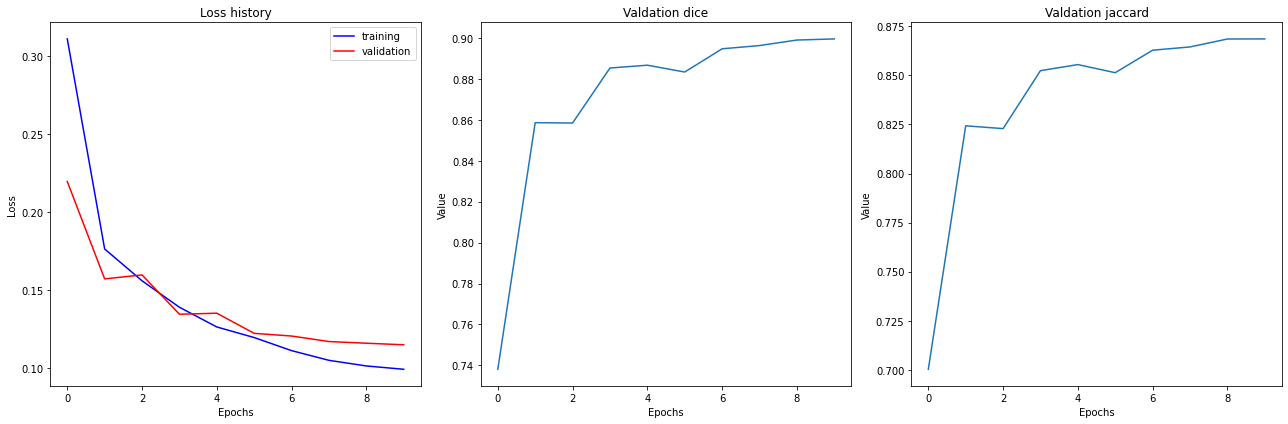

In [26]:
plot_training_history()